In [1]:
import os
import sys
# sys.path.append('/Users/wangqiqian/Desktop/TrafficTDApython/')
sys.path.append('C:/Users/USER/Desktop/TrafficTDApython/')

current_dir_path = os.getcwd()
current_file_path = os.path.abspath(current_dir_path)
current_dir_path = os.path.dirname(current_file_path)
parent_dir_path = os.path.dirname(current_dir_path)

os.chdir(current_dir_path + '\\ultils')
# os.chdir(current_dir_path + '/ultils')
print(current_dir_path)

import time
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import prince
import matplotlib.cm as cm
from matplotlib.cm import get_cmap


from functions import *
from chi import *
from regressionP import *
from models import *
from utils_v3 import *
from plots import *

# os.chdir('/Users/wangqiqian/Desktop/TrafficTDApython/')
os.chdir('C:/Users/USER/Desktop/TrafficTDApython/')


plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

c:\Users\USER\Desktop\TrafficTDApython


In [2]:
data1 = pd.read_csv("Data/NPA_TMA2_1.csv", low_memory=False)[:-2]
data2 = pd.read_csv("Data/NPA_TMA2_2.csv", low_memory=False)[:-2]
data3 = pd.read_csv("Data/NPA_TMA2_3.csv", low_memory=False)[:-2]
data4 = pd.read_csv("Data/NPA_TMA2_4_new.csv", low_memory=False)[:-2]
data5 = pd.read_csv("Data/NPA_TMA2_5.csv", low_memory=False)[:-2]
data6 = pd.read_csv("Data/NPA_TMA2_6_new.csv", low_memory=False)[:-2]
data7 = pd.read_csv("Data/NPA_TMA2_7.csv", low_memory=False)[:-2]
data8 = pd.read_csv("Data/NPA_TMA2_8.csv", low_memory=False)[:-2]
data9 = pd.read_csv("Data/NPA_TMA2_9.csv", low_memory=False)[:-2]
data10 = pd.read_csv("Data/NPA_TMA2_10.csv", low_memory=False)[:-2]

dataA2 = pd.concat([data1, data2, data3, data4, data5, data6, data7, data8, data9, data10], ignore_index=True)
# dataA2 = pd.concat([data1, data2, data3, data4, data5], ignore_index=True)

dataA1 = pd.read_csv("Data/NPA_TMA1_V3.csv")[:-2]

In [3]:
select_lst = [
    # 月份是為了篩選每個月2萬筆
    '發生月份',

    '天候名稱', '光線名稱', 
    '道路類別-第1當事者-名稱', '速限-第1當事者', 
    '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱',
    '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱',
    '號誌-號誌種類名稱', '號誌-號誌動作名稱',
    '車道劃分設施-分道設施-快車道或一般車道間名稱', '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '當事者屬-性-別名稱', '當事者事故發生時年齡',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱',
    '肇事逃逸類別名稱-是否肇逃',
    '死亡受傷人數',

    # 大類別
    '道路型態大類別名稱', '事故位置大類別名稱',
    '車道劃分設施-分向設施大類別名稱',
    '事故類型及型態大類別名稱', '當事者區分-類別-大類別名稱-車種', '當事者行動狀態大類別名稱',
    '車輛撞擊部位大類別名稱-最初', '車輛撞擊部位大類別名稱-其他',

    # 兩個欄位只有兩個觀察值不同
    '肇因研判大類別名稱-主要',
    # '肇因研判大類別名稱-個別',
]
select_lst = dataA1.columns
def preprocess(input_data, select_lst):
    # 篩選到第一個順位，因為注重的是單次事故的情況
    sample_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False)
    sample_data = sample_data[sample_data['發生月份'] < 11]
    dataA = sample_data[select_lst]
    
    # 將資料分出死亡和受傷，合併到原本的資料後去除多餘的死亡受傷人數
    death_injury_data = split_death_injury(dataA['死亡受傷人數'])
    dist_df = pd.concat([dataA, death_injury_data], axis=1)

    # 補齊缺失值
    dist_df[select_lst] = dist_df[select_lst].fillna('未紀錄')

    # 速限範圍
    dist_df = dist_df[(dist_df['速限-第1當事者'] < 200) &
                      (dist_df['當事者事故發生時年齡'] < 100) &
                      (dist_df['當事者事故發生時年齡'] > 0)]

    dist_df.drop(columns=['死亡受傷人數'], inplace=True)
    
    return dist_df

dist_dfA1 = preprocess(dataA1, select_lst)
dist_dfA2 = preprocess(dataA2, select_lst)

In [11]:
# Concat
rbind_data = pd.concat([dist_dfA1, dist_dfA2], axis=0, ignore_index=True)
rbind_data.drop(columns=['發生月份'], inplace=True)

bins_age = [0, 14, 24, 34, 44, 54, 64, 74, float('inf')]
labels_age = ['未滿15歲', '15~24', '25~34', '35~44', '45~54', '55~64', '65~74', '75+']

rbind_data['當事者事故發生時年齡'] = pd.cut(rbind_data['當事者事故發生時年齡'], bins=bins_age, labels=labels_age, right=False)

bins_speed = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, float('inf')]
labels_speed = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', '101-110', '110+']

# rbind_data['速限-第1當事者'] = pd.cut(rbind_data['速限-第1當事者'], bins=bins_speed, labels=labels_speed, right=False).astype(str)

In [38]:
for i in rbind_data.columns:
    print(rbind_data[i].value_counts())
    print('-'*100)

晴      253017
陰       31304
雨       29092
風         404
霧或煙        98
風沙         17
雪           1
Name: 天候名稱, dtype: int64
----------------------------------------------------------------------------------------------------
有照明未開啟或故障    138459
有照明且開啟        99685
無照明           75789
Name: 光線名稱, dtype: int64
----------------------------------------------------------------------------------------------------
市區道路      248164
村里道路       32563
其他         10334
縣道          7668
省道          6084
鄉道          5144
國道          2892
專用道路         806
快速(公)道       278
Name: 道路類別-第1當事者-名稱, dtype: int64
----------------------------------------------------------------------------------------------------
51-60      201614
31-40       45558
41-50       42040
61-70       12400
71-80        3688
0-10         3550
21-30        1186
110+         1089
101-110      1013
11-20         734
91-100        659
81-90         402
Name: 速限-第1當事者, dtype: int64
---------------------------------------------------------

In [23]:
rbind_data.columns

Index(['發生年度', '發生日期', '發生時間', '事故類別名稱', '處理單位名稱警局層', '發生地點', '天候名稱', '光線名稱',
       '道路類別-第1當事者-名稱', '速限-第1當事者', '道路型態大類別名稱', '道路型態子類別名稱', '事故位置大類別名稱',
       '事故位置子類別名稱', '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱', '道路障礙-障礙物名稱',
       '道路障礙-視距品質名稱', '道路障礙-視距名稱', '號誌-號誌種類名稱', '號誌-號誌動作名稱',
       '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分向設施子類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
       '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', '事故類型及型態大類別名稱',
       '事故類型及型態子類別名稱', '肇因研判大類別名稱-主要', '肇因研判子類別名稱-主要', '當事者順位',
       '當事者區分-類別-大類別名稱-車種', '當事者區分-類別-子類別名稱-車種', '當事者屬-性-別名稱', '當事者事故發生時年齡',
       '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', '當事者行動狀態大類別名稱', '當事者行動狀態子類別名稱',
       '車輛撞擊部位大類別名稱-最初', '車輛撞擊部位子類別名稱-最初', '車輛撞擊部位大類別名稱-其他', '車輛撞擊部位子類別名稱-其他',
       '肇因研判大類別名稱-個別', '肇因研判子類別名稱-個別', '肇事逃逸類別名稱-是否肇逃', '經度', '緯度', '死亡', '受傷',
       '縣市'],
      dtype='object')

In [24]:
rbind_data['道路類別-第1當事者-名稱']

0           省道
1         市區道路
2           縣道
3         市區道路
4           省道
          ... 
313928    市區道路
313929    市區道路
313930    市區道路
313931    市區道路
313932    市區道路
Name: 道路類別-第1當事者-名稱, Length: 313933, dtype: object

In [45]:
death_rate_summary = (
    rbind_data.groupby("事故類型及型態子類別名稱")
    .agg(
        總事故數=("死亡", "count"),  # 計算該類別的總事故數
        死亡事故數=("死亡", "sum")   # 計算該類別的死亡事故數
    )
    .assign(死亡比例=lambda x: x["死亡事故數"] / x["總事故數"])  # 計算死亡率
    .reset_index()  # 重置索引，轉回普通欄位
)
death_rate_summary = death_rate_summary[death_rate_summary["總事故數"] > 300]
death_rate_summary.sort_values("死亡比例", ascending=False)

,事故類型及型態子類別名稱,總事故數,死亡事故數,死亡比例
20,撞電桿,1396,75,0.053725
19,撞路樹,496,25,0.050403
18,撞護欄(樁),2025,73,0.036049
12,撞交通島,950,34,0.035789
24,衝出路外,1610,56,0.034783
15,撞建築物,329,11,0.033435
17,撞號誌、標誌桿,783,23,0.029374
23,穿越道路中,7166,121,0.016885
0,佇立路邊(外),312,5,0.016026
10,對撞,2632,37,0.014058


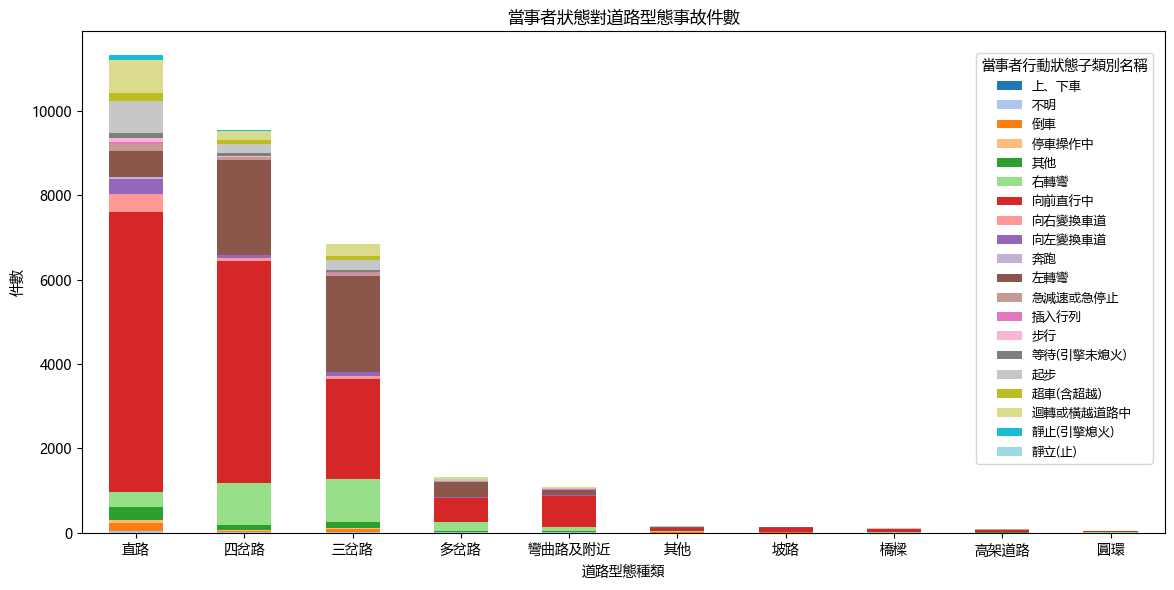

In [5]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

choose = "當事者行動狀態子類別名稱"

f_rbind_data = rbind_data[rbind_data['車輛撞擊部位子類別名稱-其他'] != '未紀錄']
cross_tab = pd.crosstab(
    f_rbind_data["道路型態子類別名稱"],
    f_rbind_data[choose]
)

# 排序並刪除臨時總數欄位
cross_tab = cross_tab.assign(總數=cross_tab.sum(axis=1)).sort_values(by="總數", ascending=False).drop(columns=["總數"]).head(10)

# 獲取類別數量
num_categories = cross_tab.columns.size

# 自定義顏色調色盤
colors = cm.get_cmap('tab20', num_categories)  # 使用 'tab20' 調色盤，支持最多 20 種顏色

# 繪製堆疊柱狀圖
ax = cross_tab.plot(kind="bar", stacked=True, figsize=(12, 6), color=[colors(i) for i in range(num_categories)])
plt.title("當事者狀態對道路型態事故件數")
plt.xlabel("道路型態種類")
plt.ylabel("件數")
plt.legend(title=choose, bbox_to_anchor=(0.82, 0.97), loc="upper left", fontsize=9)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

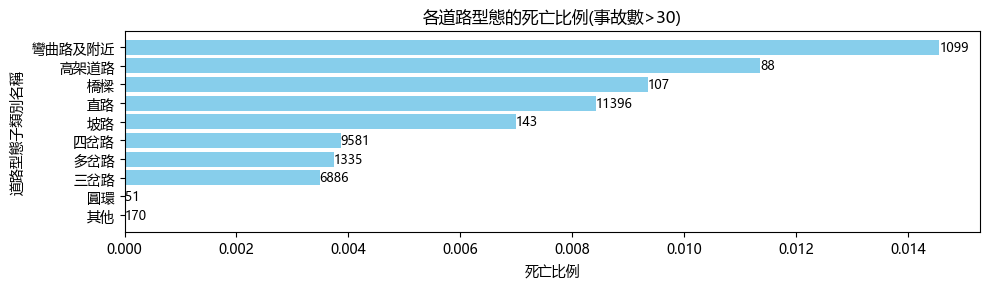

In [195]:
summary = (
    f_rbind_data.groupby("道路型態子類別名稱")
    .agg(總事故數=("死亡", "count"), 死亡事故數=("死亡", "sum"))
    .assign(死亡比例=lambda x: x["死亡事故數"] / x["總事故數"])
    .reset_index()
)
summary = summary[summary["總事故數"] > 30].sort_values(by="死亡比例", ascending=True)

# 繪製條形圖
plt.figure(figsize=(10, 3))
bars = plt.barh(summary["道路型態子類別名稱"], summary["死亡比例"], color="skyblue")

# 添加總事故數作為標籤
for bar, total in zip(bars, summary["總事故數"]):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f"{total}", va="center", fontsize=9)

plt.title("各道路型態的死亡比例(事故數>30)")
plt.xlabel("死亡比例")
plt.ylabel("道路型態子類別名稱")
plt.tight_layout()
plt.show()

In [17]:
a= rbind_data[rbind_data['道路型態子類別名稱'] == '隧道']
a['死亡'].value_counts()

0    162
1      3
Name: 死亡, dtype: int64

C:\Users\USER\AppData\Local\Temp\ipykernel_29848\3332407018.py:31: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


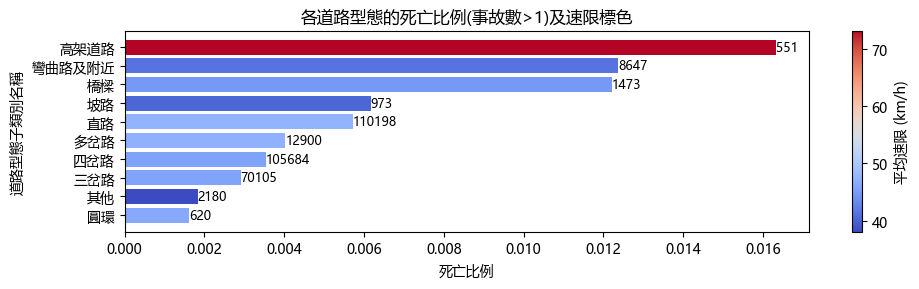

In [18]:
summary = (
    rbind_data.groupby("道路型態子類別名稱")
    .agg(
        總事故數=("死亡", "count"),
        死亡事故數=("死亡", "sum"),
        平均速限=("速限-第1當事者", "mean")
    )
    .assign(死亡比例=lambda x: x["死亡事故數"] / x["總事故數"])
    .reset_index()
)

# 篩選總事故數大於 1 並按死亡比例排序
summary = summary[summary["總事故數"] > 300].sort_values(by="死亡比例", ascending=True)

# 分配顏色：根據平均速限分配顏色（標準化速限值）
norm = plt.Normalize(summary["平均速限"].min(), summary["平均速限"].max())
colors = plt.cm.coolwarm(norm(summary["平均速限"]))

# 繪製條形圖
plt.figure(figsize=(10, 3))
bars = plt.barh(summary["道路型態子類別名稱"], summary["死亡比例"], color=colors)

# 添加總事故數作為標籤
for bar, total in zip(bars, summary["總事故數"]):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f"{total}", va="center", fontsize=9)

# 添加顏色條（Colorbar）以顯示速限範圍
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label("平均速限 (km/h)")

plt.title("各道路型態的死亡比例(事故數>1)及速限標色")
plt.xlabel("死亡比例")
plt.ylabel("道路型態子類別名稱")
plt.tight_layout()
plt.show()

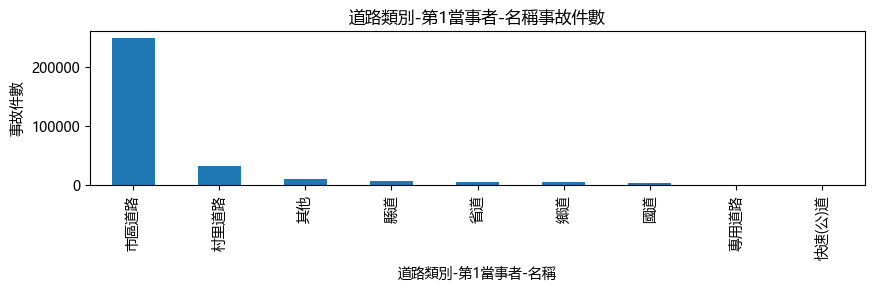

In [19]:
road_quality_counts = rbind_data["道路類別-第1當事者-名稱"].value_counts()
road_quality_counts.sort_values(ascending=False).plot(kind="bar", figsize=(10, 2))
plt.title("道路類別-第1當事者-名稱事故件數")
plt.xlabel("道路類別-第1當事者-名稱")
plt.ylabel("事故件數")
plt.xticks()
plt.show()



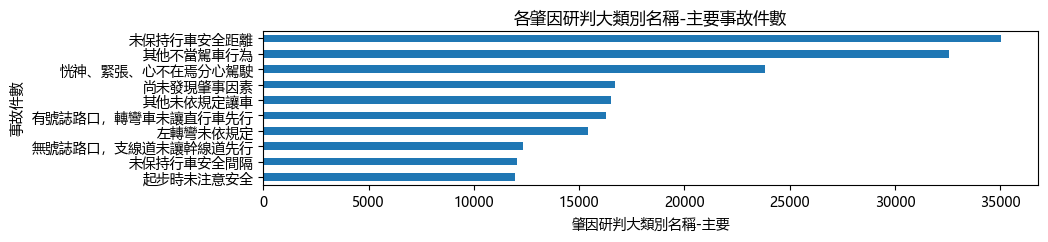

In [20]:
cause_counts = rbind_data["肇因研判子類別名稱-個別"].value_counts().head(10)
cause_counts.sort_values(ascending=True).plot(kind="barh", figsize=(10, 2))
plt.title("各肇因研判大類別名稱-主要事故件數")
plt.xlabel("肇因研判大類別名稱-主要")
plt.ylabel("事故件數")
plt.xticks()
plt.show()


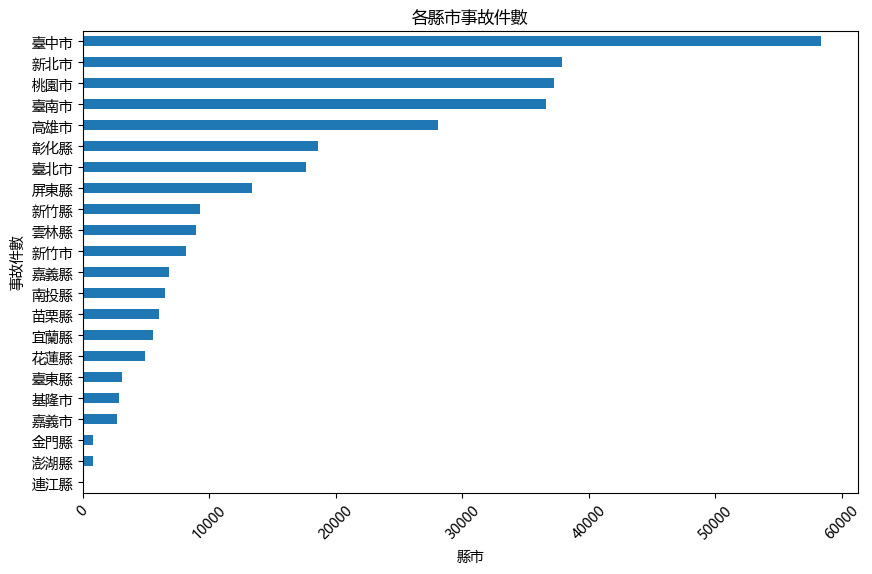

In [21]:
rbind_data["縣市"] = rbind_data["發生地點"].str[:3]

location_counts = rbind_data["縣市"].value_counts()

location_counts.sort_values(ascending=True).plot(kind="barh", figsize=(10, 6))
plt.title("各縣市事故件數")
plt.xlabel("縣市")
plt.ylabel("事故件數")
plt.xticks(rotation=45)
plt.show()

In [38]:
import folium
from folium.plugins import HeatMap

heat_data  = rbind_data[["緯度", "經度"]].dropna().values.tolist()

map_taiwan = folium.Map(location=[23.5, 121], zoom_start=7)

HeatMap(heat_data, 
        radius=10,
        blur=15,
        ).add_to(map_taiwan)

map_taiwan.save("traffic_heatmap.html")

In [49]:
from scipy.stats import gaussian_kde

coords = rbind_data[["緯度", "經度"]].dropna().values.T

# 計算 KDE
kde = gaussian_kde(coords)
x_min, x_max = coords[1].min() - 0.01, coords[1].max() + 0.01  # 經度範圍
y_min, y_max = coords[0].min() - 0.01, coords[0].max() + 0.01  # 緯度範圍
x, y = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]  # 生成網格
positions = np.vstack([y.ravel(), x.ravel()])  # KDE 需要緯度在前，經度在後
density = kde(positions).reshape(x.shape)  # KDE 計算密度

# 將 KDE 結果添加到地圖
map_taiwan = folium.Map(location=[23.5, 121], zoom_start=7)

# 將 KDE 結果標準化
density = (density - density.min()) / (density.max() - density.min())

# 將密度轉為 folium 格式
for i in range(density.shape[0]):
    for j in range(density.shape[1]):
        if density[i, j] > 0.01:  # 過濾較低的密度值
            folium.CircleMarker(
                location=[y[i, j], x[i, j]],
                radius=5,
                weight=0,
                fill=True,
                fill_opacity=density[i, j],
                fill_color="red"
            ).add_to(map_taiwan)

# 儲存結果
map_taiwan.save("traffic_kde_map.html")